#Creazione classe dataset

In [ ]:
import torch
import numpy as np
import pandas as pd
import fiona
import os
import cv2

!pip install rasterio
!pip install geopandas
!pip install matplotlib

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive', force_remount=True)
percorso =  "/content/drive/MyDrive/Progetto_laboratorio"


In [89]:
from torch.utils.data import Dataset
import json
from shapely.geometry import shape,mapping
from shapely.affinity import scale
from rasterio.enums import Resampling
from rasterio.features import rasterize
from datetime import datetime
import re
import torch.nn.functional as F
from PIL import Image

class Dataset(Dataset):
  def __init__(self,root,transform = None):
    self.root = root  #directory radice
    self.transform = transform
    self.zones = self.load_zones()


  def load_zones(self):
    zones = {}       #dizionario dove ad ogni chiave corrispondono
    #itero attraverso le cartelle per trovare percorsi delle immagini
    for zone in os.listdir(self.root):
      zone_path = os.path.join(self.root,zone)
      if os.path.isdir(zone_path):
        zones[zone] = self.load_images_and_labels(zone_path)
    return zones

  def load_images_and_labels(self,zone_path):
    image_label_pairs = []
    if os.path.isdir(zone_path):
      images_dir = os.path.join(zone_path, 'images_masked')     #directory con immagini
      labels_dir = os.path.join(zone_path, 'labels_match')      #directory con labels
      if os.path.exists(images_dir) and os.path.exists(labels_dir):
        for image_file in os.listdir(images_dir):
          if (image_file.endswith('.tif')):
            image_path = os.path.join(images_dir,image_file)
            label_file = os.path.splitext(image_file)[0] + '_Buildings.geojson'
            label_path = os.path.join(labels_dir,label_file)

            if os.path.exists(label_path):

                date_str = re.search(r'\d{4}_\d{2}', image_file).group()
                date = datetime.strptime(date_str, '%Y_%m')
                image_label_pairs.append((image_path, label_path, date))

              #image_label_pairs.append((image_path,label_path))

    image_label_pairs.sort(key=lambda x: x[2])
    image_label_pairs = [(image_path, label_path) for image_path, label_path, date in image_label_pairs]

    return image_label_pairs



  def __len__(self):
    return len(list(self.zones.keys()))

  def _resize_image(self, image, target_size=(1024, 1024)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)


  def resize_image(self,image, new_shape, src_crs, dst_crs):
    resized_image = np.zeros((image.shape[0], new_shape[0], new_shape[1]), dtype=np.float32)
    for i in range(image.shape[0]):
        resized_image[i] = rasterio.warp.reproject(
            source=image[i],
            destination=np.empty(new_shape, dtype=np.float32),
            src_transform=rasterio.transform.from_bounds(0, 0, image.shape[2], image.shape[1], image.shape[2], image.shape[1]),
            dst_transform=rasterio.transform.from_bounds(0, 0, new_shape[1], new_shape[0], new_shape[1], new_shape[0]),
            src_crs=src_crs,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )[0]
    return resized_image

  def resize_geojson(self,geojson, scale_factor):
    for feature in geojson['features']:
        geom = shape(feature['geometry'])
        scaled_geom = scale(geom, xfact=scale_factor, yfact=scale_factor)
        feature['geometry'] = mapping(scaled_geom)
    return geojson

  def __getitem__(self,idx):

    if isinstance(idx,list):
        idx = idx[0]

    zone_keys = list(self.zones.keys())
    zone = zone_keys[idx]

    image_path1,label_path1 = self.zones[zone][0]
    image_path2,label_path2 = self.zones[zone][-1]

    with rasterio.open(image_path1) as src1, rasterio.open(image_path2) as src2:
      image1 = src1.read().astype(np.float32)[:3,:,:]
      image2 = src2.read().astype(np.float32)[:3,:,:]
      out_shape = (src1.height, src1.width)

      if image1.shape[1:] != (1024, 1024):
        image1 = self._resize_image(image1.transpose(1, 2, 0)).transpose(2, 0, 1)
        out_shape = (image1.shape[1], image1.shape[2])
      if image2.shape[1:] != (1024, 1024):
        image2 = self._resize_image(image2.transpose(1, 2, 0)).transpose(2, 0, 1)
      out_shape = (image2.shape[1], image2.shape[2])

      src_crs = src1.crs
      dst_crs = src_crs

      scale_factor = 512/1024
      image1=self.resize_image(image1, (512,512), src_crs, dst_crs)
      image2=self.resize_image(image2, (512,512), src_crs, dst_crs)

      with open(label_path1) as label1, open(label_path2) as label2:
        geojson1 = json.load(label1)
        geojson2 = json.load(label2)

      print("GeoJSON1 preridimensionato:", len(geojson1['features']))
      print("GeoJSON2 preridimensionato:", len(geojson2['features']))

      geojson1 = self.resize_geojson(geojson1, scale_factor)
      geojson2 = self.resize_geojson(geojson2, scale_factor)

      print("GeoJSON1 ridimensionato:", len(geojson1['features']))
      print("GeoJSON2 ridimensionato:", len(geojson2['features']))

      mask1 = self.create_mask(geojson1, (512,512), src1.transform)
      mask2 = self.create_mask(geojson2, (512,512), src2.transform)


      if self.transform:
        if not isinstance(image1,np.ndarray):
            image1 = image1.numpy()
        if not isinstance(image2,np.ndarray):
            image2 = image2.numpy()

        if not isinstance(mask1,np.ndarray):
            mask1 = mask1.numpy()
        if not isinstance(mask2,np.ndarray):
            mask2 = mask2.numpy()

        augmented1 = self.transform(image=np.transpose(image1,(1,2,0)), mask=mask1)
        augmented2 = self.transform(image=np.transpose(image2,(1,2,0)), mask=mask2)
        image1 = np.transpose(augmented1['image'],(2,1,0))
        mask1 = augmented1['mask']
        image2 = np.transpose(augmented2['image'],(2,1,0))
        mask2 = augmented2['mask']

    if not isinstance(image1,np.ndarray):
      image1 = image1.numpy()
    if not isinstance(image2,np.ndarray):
      image2 = image2.numpy()

    image1_tensor = torch.from_numpy(image1)
    print(image1_tensor.shape)
    image2_tensor = torch.from_numpy(image2)
    if (image1_tensor.shape[0] != 3 and image1_tensor.shape[2] == 3):
      image1_tensor = image1_tensor.permute(2,1,0)
    if (image2_tensor.shape[0] != 3 and image2_tensor.shape[2] == 3):
      image2_tensor = image2_tensor.permute(2,1,0)
    if (image1_tensor.shape[0] != 3 and image1_tensor.shape[1] == 3):
      image1_tensor = image1_tensor.permute(1,2,0)
    if (image2_tensor.shape[0] != 3 and image2_tensor.shape[1] == 3):
      image2_tensor = image2_tensor.permute(1,2,0)


    images = torch.cat([image1_tensor,image2_tensor],dim=0)
    print(images.shape)

    if not isinstance(mask1,np.ndarray):
      mask1 = mask1.numpy()
    print(np.sum(mask1==1))
    if not isinstance(mask2,np.ndarray):
      mask2 = mask2.numpy()
    print(np.sum(mask2==1))

    mask1_tensor = torch.from_numpy(mask1)
    mask2_tensor = torch.from_numpy(mask2)
    masks = torch.logical_xor(mask1_tensor, mask2_tensor).to(torch.uint8).numpy()
    #print(images.shape)
    #print(masks.shape)
    if (images.shape[0] != 6 and images.shape[2]==6):
        images.permute(2,1,0)
    if (images.shape[0] != 6 and images.shape[1]==6):
        images.permute(1,2,0)
    print(np.sum(masks==1))
    images=images.numpy()
    return images, masks


  def create_mask(self, geojson, out_shape, transform):
        if 'features' in geojson and len(geojson['features']) > 0:
            gdf = gpd.GeoDataFrame.from_features(geojson['features'])
            if not gdf.empty and gdf.geometry.notnull().any():
                mask = rasterize([(geom, 1) for geom in gdf.geometry], out_shape=out_shape, transform=transform, fill=0, dtype='uint8')
            else:
                mask = np.zeros(out_shape, dtype='uint8')
        else:
            mask = np.zeros(out_shape, dtype='uint8')
        return mask

In [90]:
train_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/train")
test_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/test")
val_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/validation")

key = next(iter(test_dataset.zones))
#print(test_dataset.zones)
#for zone in train_dataset.zones:
  #dataset_train_raster[zone] = train_dataset[zone]
#for zone in test_dataset.zones:
  #dataset_test_raster[zone] = test_dataset[zone]
#for zone in val_dataset.zones:
  #dataset_val_raster[zone] = val_dataset[zone]

In [ ]:
from rasterio.plot import show
for zone in range(0,len(test_dataset)):
  print(np.sum(test_dataset[zone][1]==1))

# Visualizza l'immagine e le etichette rasterizzate
  fig, ax = plt.subplots()
  show(test_dataset[zone][0][1].astype(np.int32), ax=ax, title='Immagine con Etichette Rasterizzate')
  ax.imshow(arr, cmap='Reds', alpha=0.5)
  plt.show()

GeoJSON1 preridimensionato: 1371
GeoJSON2 preridimensionato: 1691
GeoJSON1 ridimensionato: 1371
GeoJSON2 ridimensionato: 1691
torch.Size([3, 512, 512])
torch.Size([6, 512, 512])
3428
4695
1279


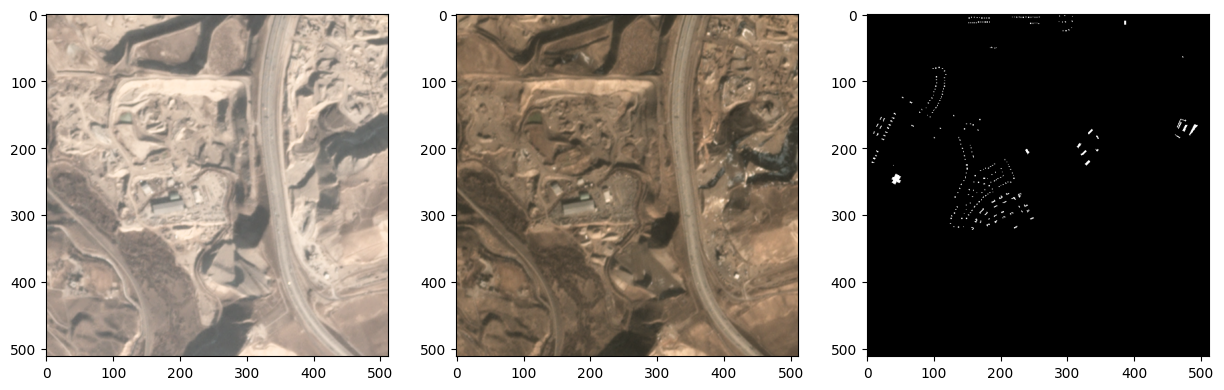

In [98]:
import matplotlib.pyplot as plt

def show_sample(images, masks):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(torch.from_numpy(images[:3].astype(np.int32)).permute(1, 2, 0))  # Prima immagine
    ax[1].imshow(torch.from_numpy(images[3:].astype(np.int32)).permute(1, 2, 0))  # Seconda immagine
    ax[2].imshow(torch.from_numpy(masks), cmap='gray')  # Maschera
    plt.show()

# Ottieni un campione dal dataset
images, masks = train_dataset[0]
show_sample(images, masks)

In [ ]:
for zone in range(0,len(train_dataset)):
  train_dataset[zone]
for zone in range(0,len(val_dataset)):
  val_dataset[zone]
for zone in range(0,len(test_dataset)):
  test_dataset[zone]

CRSError: Missing src_crs.